# 27a: E[Q] 3D Surface by Domino and Move Number

**Goal**: Create a 3D matplotlib visualization showing E[Q] for every domino across move numbers.

**Axes**:
- X: Domino ID (0-27)
- Y: Move Number (1-28)
- Z: E[Q] (expected value)

This reveals patterns in domino value across the game timeline.

In [1]:
# === CONFIGURATION ===
DATA_PATH = "/home/jason/v2/mk5-tailwind/forge/data/eq_v2.2_250g.pt"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

from forge.analysis.utils import viz
from forge.oracle import schema

viz.setup_notebook_style()
print("✓ Ready")

✓ Ready


## 1. Load E[Q] Data

In [2]:
# Load E[Q] dataset
print(f"Loading {DATA_PATH}...")
data = torch.load(DATA_PATH, weights_only=False)

n_decisions = len(data['e_q_mean'])
n_games = data['game_idx'].max().item() + 1
print(f"Loaded {n_decisions:,} decisions from {n_games} games")
print(f"E[Q] shape: {data['e_q_mean'].shape}")

Loading /home/jason/v2/mk5-tailwind/forge/data/eq_v2.2_250g.pt...
Loaded 7,000 decisions from 250 games
E[Q] shape: torch.Size([7000, 7])


## 2. Extract Domino IDs from Tokens

The E[Q] values are indexed by local slot (0-6), not global domino ID (0-27).
We need to decode the transcript tokens to map slots to dominoes.

In [3]:
# Token feature indices (from render_visualizations.py)
FEAT_HIGH = 0
FEAT_LOW = 1
FEAT_TOKEN_TYPE = 7
TOKEN_TYPE_HAND = 1

def pips_to_domino_id(high, low):
    """Convert (high, low) pips to domino ID (0-27).
    
    Domino IDs are assigned as: ID = h*(h+1)/2 + l for h >= l
    """
    h, l = max(high, low), min(high, low)
    return h * (h + 1) // 2 + l

def extract_hand_dominoes(tokens, length):
    """Extract list of domino IDs from transcript tokens.
    
    Returns list of domino IDs in slot order (0-6).
    """
    hand = []
    for i in range(length):
        if tokens[i, FEAT_TOKEN_TYPE] == TOKEN_TYPE_HAND:
            high = tokens[i, FEAT_HIGH].item()
            low = tokens[i, FEAT_LOW].item()
            domino_id = pips_to_domino_id(high, low)
            hand.append(domino_id)
    return hand

# Test
test_hand = extract_hand_dominoes(data['transcript_tokens'][0], data['transcript_lengths'][0].item())
print(f"Example hand dominoes (first decision): {test_hand}")
print(f"As pips: {[schema.domino_pips(d) for d in test_hand]}")

Example hand dominoes (first decision): [3, 8, 12, 16, 18, 19, 26]
As pips: [(2, 0), (3, 2), (4, 2), (5, 1), (5, 3), (5, 4), (6, 5)]


## 3. Build E[Q] by Domino and Move Number

In [4]:
# Collect E[Q] values for each (domino_id, move_number) pair
# Structure: eq_by_domino_move[domino_id][move_num] = list of E[Q] values
eq_by_domino_move = defaultdict(lambda: defaultdict(list))

tokens = data['transcript_tokens']
lengths = data['transcript_lengths']
e_q_mean = data['e_q_mean']
legal_mask = data['legal_mask']
decision_idx = data['decision_idx']

print("Processing decisions...")
for i in range(n_decisions):
    if i % 1000 == 0:
        print(f"  {i:,}/{n_decisions:,}", end='\r')
    
    # Get hand dominoes for this decision
    hand = extract_hand_dominoes(tokens[i], lengths[i].item())
    
    # Move number (1-indexed for readability)
    move_num = decision_idx[i].item() + 1
    
    # For each legal domino in hand, record its E[Q]
    for slot, domino_id in enumerate(hand):
        if slot < 7 and legal_mask[i, slot].item():
            eq_val = e_q_mean[i, slot].item()
            eq_by_domino_move[domino_id][move_num].append(eq_val)

print(f"\n✓ Processed {n_decisions:,} decisions")
print(f"Unique dominoes with data: {len(eq_by_domino_move)}")

Processing decisions...


  6,000/7,000
✓ Processed 7,000 decisions
Unique dominoes with data: 28


## 4. Create E[Q] Matrix

In [5]:
# Create 28x28 matrix: rows = dominoes (0-27), cols = move numbers (1-28)
# Value = mean E[Q] for that domino at that move number
eq_matrix = np.full((28, 28), np.nan)
count_matrix = np.zeros((28, 28), dtype=int)

for domino_id in range(28):
    for move_num in range(1, 29):
        vals = eq_by_domino_move[domino_id].get(move_num, [])
        if vals:
            eq_matrix[domino_id, move_num - 1] = np.mean(vals)
            count_matrix[domino_id, move_num - 1] = len(vals)

# Statistics
valid_mask = ~np.isnan(eq_matrix)
print(f"Valid cells: {valid_mask.sum()} / {28*28} ({100*valid_mask.sum()/(28*28):.1f}%)")
print(f"E[Q] range: [{np.nanmin(eq_matrix):.2f}, {np.nanmax(eq_matrix):.2f}]")
print(f"E[Q] mean: {np.nanmean(eq_matrix):.2f}")

Valid cells: 784 / 784 (100.0%)
E[Q] range: [-17.00, 17.03]
E[Q] mean: -2.28


## 5. Reorder Dominoes to Minimize Neighbor Deltas

Sort dominoes by their average E[Q] to create a smoother surface.

/tmp/ipykernel_1594397/3679188659.py:98: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


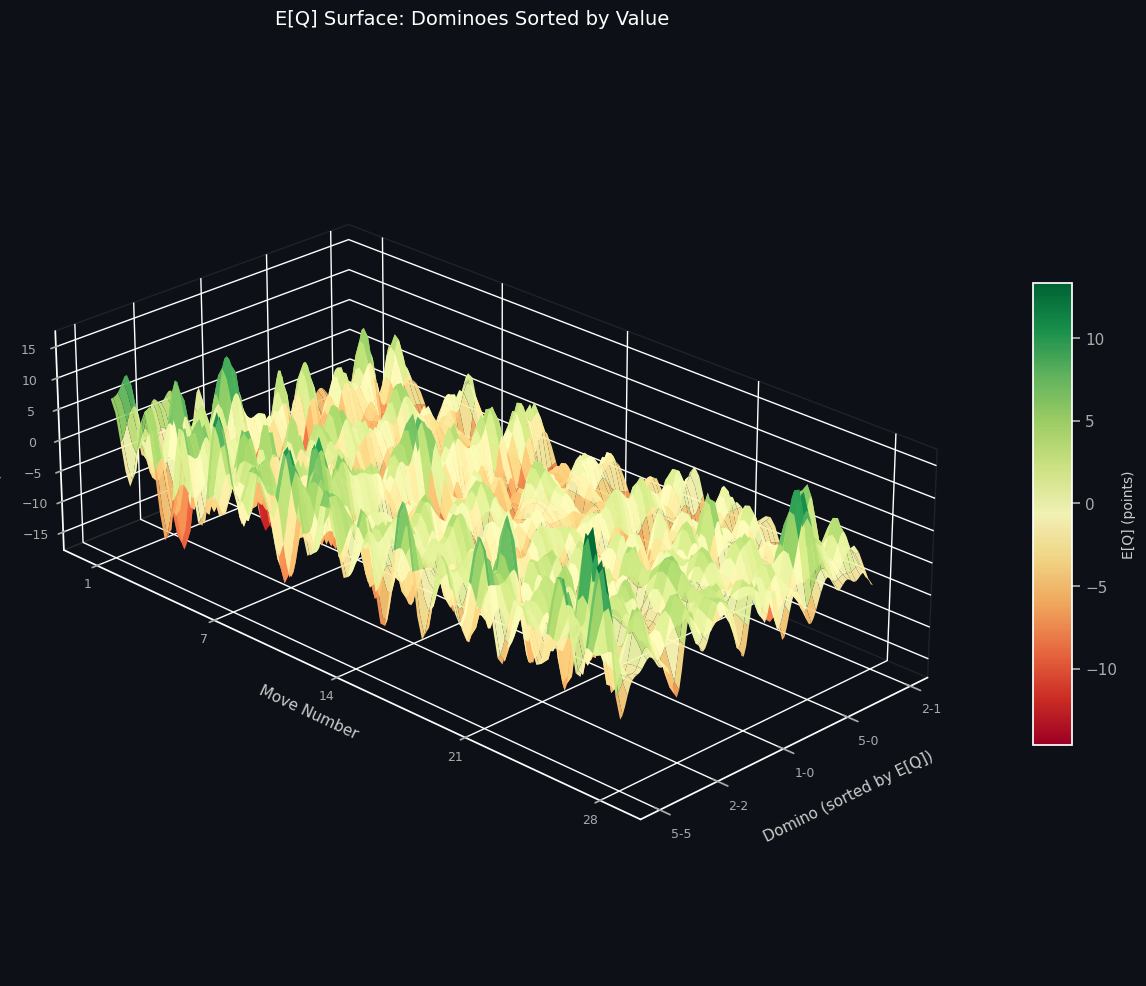


Domino order (sorted by avg E[Q]):
   0: 2-1 (E[Q]=-5.05)   1: 3-2 (E[Q]=-3.86)   2: 5-1 (E[Q]=-3.78)   3: 3-1 (E[Q]=-3.76)
   4: 2-0 (E[Q]=-3.70)   5: 6-0 (E[Q]=-3.69)   6: 4-1 (E[Q]=-3.62)   7: 5-0 (E[Q]=-3.57)
   8: 4-2 (E[Q]=-3.51)   9: 5-2 (E[Q]=-3.48)  10: 3-0 (E[Q]=-3.38)  11: 6-3 (E[Q]=-3.33)
  12: 6-1 (E[Q]=-3.22)  13: 4-0 (E[Q]=-2.99)  14: 1-0 (E[Q]=-2.79)  15: 4-3 (E[Q]=-2.39)
  16: 5-4 (E[Q]=-2.25)  17: 5-3 (E[Q]=-2.22)  18: 0-0 (E[Q]=-2.10)  19: 6-2 (E[Q]=-2.06)
  20: 6-5 (E[Q]=-1.58)  21: 2-2 (E[Q]=-0.93)  22: 3-3 (E[Q]=-0.41)  23: 1-1 (E[Q]=+0.15)
  24: 6-4 (E[Q]=+0.18)  25: 6-6 (E[Q]=+0.61)  26: 4-4 (E[Q]=+0.82)  27: 5-5 (E[Q]=+2.04)

✓ Saved: results/figures/27a_eq_surface_3d.png


In [6]:
# Sort dominoes by average E[Q] to minimize neighbor deltas
eq_by_domino = np.nanmean(eq_matrix, axis=1)
sorted_domino_idx = np.argsort(eq_by_domino)  # Low to high E[Q]

# Reorder the matrix rows
eq_matrix_sorted = eq_matrix[sorted_domino_idx, :]

# Interpolation for smooth surface
from scipy.ndimage import zoom

# Upsample for smoothness (4x in both dimensions)
Z_smooth = zoom(eq_matrix_sorted.T, zoom=4, order=3)  # Cubic interpolation

# Create coordinate arrays with proper spacing:
# - Domino axis: 0-27 with gaps (each domino gets width ~0.7, gap ~0.3)
# - Move axis: 2x longer than domino axis is wide
n_dominoes = 28
n_moves = 28
domino_width = 0.7
domino_gap = 0.3
domino_spacing = domino_width + domino_gap

# Domino positions (with gaps)
domino_centers = np.arange(n_dominoes) * domino_spacing

# Move positions (2:1 aspect ratio relative to total domino width)
total_domino_width = n_dominoes * domino_spacing
move_length = total_domino_width * 2
move_positions = np.linspace(0, move_length, n_moves)

# Create high-res grids for smooth surface
n_smooth = Z_smooth.shape[0]  # Upsampled resolution
X_smooth = np.linspace(domino_centers[0], domino_centers[-1], Z_smooth.shape[1])
Y_smooth = np.linspace(0, move_length, Z_smooth.shape[0])
X_mesh, Y_mesh = np.meshgrid(X_smooth, Y_smooth)

# For the strip effect: create separate surfaces per domino
# We'll use the smooth interpolated data

# Dark mode style
plt.style.use('dark_background')

fig = plt.figure(figsize=(16, 12), facecolor='#0d1117')
ax = fig.add_subplot(111, projection='3d', facecolor='#0d1117')

# Plot smooth surface
surf = ax.plot_surface(
    X_mesh, Y_mesh, Z_smooth,
    cmap=cm.RdYlGn,
    linewidth=0,
    antialiased=True,
    alpha=0.95,
    rcount=100,
    ccount=100,
)

# Style the axes for dark mode
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('#333333')
ax.yaxis.pane.set_edgecolor('#333333')
ax.zaxis.pane.set_edgecolor('#333333')
ax.tick_params(colors='#aaaaaa', labelsize=9)
ax.xaxis.label.set_color('#cccccc')
ax.yaxis.label.set_color('#cccccc')
ax.zaxis.label.set_color('#cccccc')

# Labels
ax.set_xlabel('Domino (sorted by E[Q])', fontsize=11, labelpad=12)
ax.set_ylabel('Move Number', fontsize=11, labelpad=12)
ax.set_zlabel('E[Q] (points)', fontsize=11, labelpad=8)
ax.set_title('E[Q] Surface: Dominoes Sorted by Value', fontsize=14, pad=20, color='white')

# Colorbar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=12, pad=0.08)
cbar.set_label('E[Q] (points)', fontsize=10, color='#cccccc')
cbar.ax.yaxis.set_tick_params(color='#aaaaaa')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#aaaaaa')

# X-axis ticks showing domino pips at key positions
key_positions = [0, 7, 14, 21, 27]
key_x = [domino_centers[p] for p in key_positions]
key_labels = [f"{schema.domino_pips(sorted_domino_idx[p])[0]}-{schema.domino_pips(sorted_domino_idx[p])[1]}" 
              for p in key_positions]
ax.set_xticks(key_x)
ax.set_xticklabels(key_labels, fontsize=9)

# Y-axis ticks showing move numbers
y_ticks = [0, move_length/4, move_length/2, 3*move_length/4, move_length]
ax.set_yticks(y_ticks)
ax.set_yticklabels(['1', '7', '14', '21', '28'])

# Set viewing angle (zoomed out)
ax.view_init(elev=25, azim=45)
ax.set_box_aspect([1, 2, 0.6])  # Stretch Y axis, compress Z

plt.tight_layout()
plt.savefig('../../results/figures/27a_eq_surface_3d.png', dpi=150, bbox_inches='tight', 
            facecolor='#0d1117', edgecolor='none')
plt.show()

# Print sorting info
print("\nDomino order (sorted by avg E[Q]):")
for i, idx in enumerate(sorted_domino_idx):
    pips = schema.domino_pips(idx)
    print(f"  {i:2}: {pips[0]}-{pips[1]} (E[Q]={eq_by_domino[idx]:+.2f})", end='')
    if (i + 1) % 4 == 0:
        print()
print("\n✓ Saved: results/figures/27a_eq_surface_3d.png")

## 6. Ribbon Strip View (Gaps Between Dominoes)

/tmp/ipykernel_1594397/4119130398.py:77: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


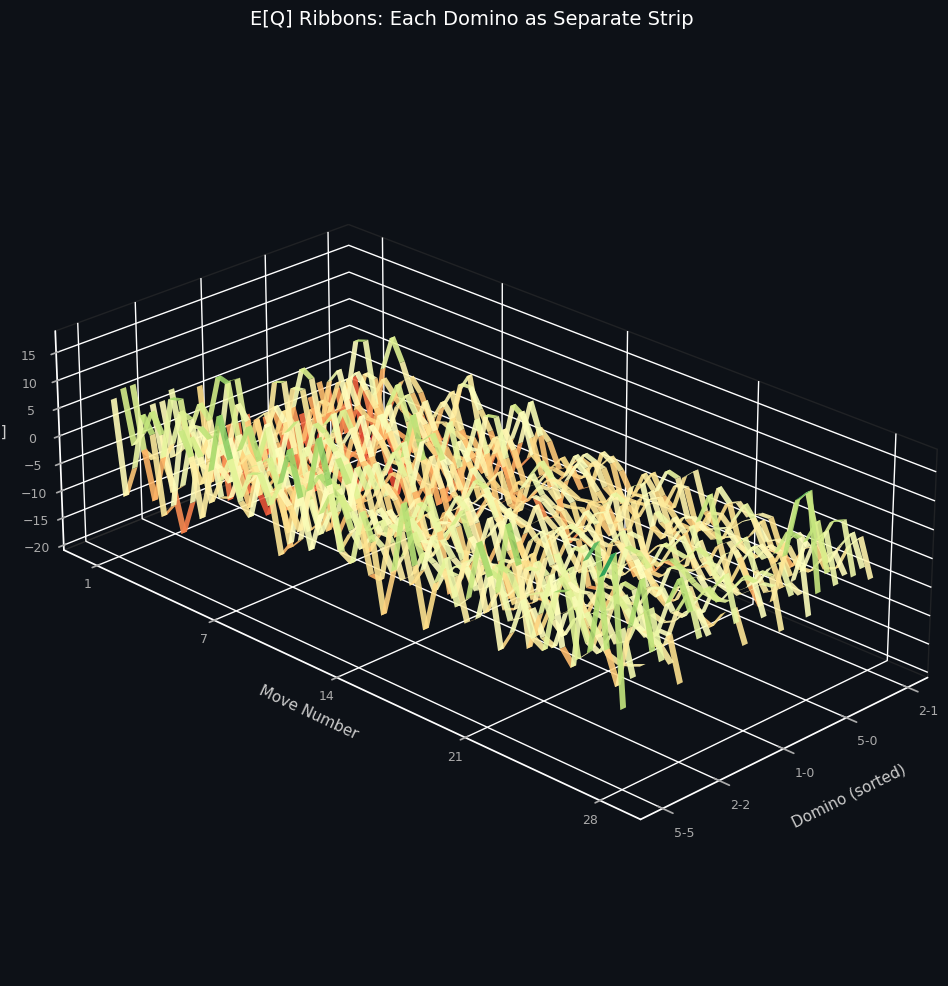

✓ Saved: results/figures/27a_eq_ribbons.png


In [7]:
# Ribbon strip view - each domino as separate strip with gaps
from scipy.interpolate import interp1d

plt.style.use('dark_background')
fig = plt.figure(figsize=(16, 12), facecolor='#0d1117')
ax = fig.add_subplot(111, projection='3d', facecolor='#0d1117')

# Parameters for strip layout
strip_width = 0.6
gap_width = 0.4
strip_res = 50  # Points along each strip for smoothness

# High-res Y coordinates for smooth strips
Y_hires = np.linspace(0, move_length, strip_res)

# Plot each domino as a separate ribbon strip
for d_idx in range(n_dominoes):
    # X position for this domino's strip
    x_center = d_idx * domino_spacing
    x_left = x_center - strip_width / 2
    x_right = x_center + strip_width / 2
    
    # Get E[Q] values for this domino across moves
    eq_values = eq_matrix_sorted[d_idx, :]
    
    # Interpolate for smooth curve
    move_indices = np.arange(n_moves)
    f_interp = interp1d(move_indices, eq_values, kind='cubic')
    eq_smooth = f_interp(np.linspace(0, n_moves - 1, strip_res))
    
    # Create strip mesh
    X_strip = np.array([x_left, x_right])
    Y_strip = Y_hires
    X_strip_mesh, Y_strip_mesh = np.meshgrid(X_strip, Y_strip)
    Z_strip_mesh = np.column_stack([eq_smooth, eq_smooth])
    
    # Color based on mean E[Q] for this domino
    mean_eq = eq_by_domino[sorted_domino_idx[d_idx]]
    norm_val = (mean_eq + 20) / 40  # Normalize to 0-1
    
    ax.plot_surface(
        X_strip_mesh, Y_strip_mesh, Z_strip_mesh,
        cmap=cm.RdYlGn,
        linewidth=0,
        antialiased=True,
        alpha=0.9,
        vmin=-20, vmax=20,
    )

# Style dark mode
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('#333333')
ax.yaxis.pane.set_edgecolor('#333333')
ax.zaxis.pane.set_edgecolor('#333333')
ax.tick_params(colors='#aaaaaa', labelsize=9)
ax.xaxis.label.set_color('#cccccc')
ax.yaxis.label.set_color('#cccccc')
ax.zaxis.label.set_color('#cccccc')

ax.set_xlabel('Domino (sorted)', fontsize=11, labelpad=12)
ax.set_ylabel('Move Number', fontsize=11, labelpad=12)
ax.set_zlabel('E[Q]', fontsize=11, labelpad=8)
ax.set_title('E[Q] Ribbons: Each Domino as Separate Strip', fontsize=14, pad=20, color='white')

# Ticks
ax.set_xticks([domino_centers[p] for p in [0, 7, 14, 21, 27]])
ax.set_xticklabels([f"{schema.domino_pips(sorted_domino_idx[p])[0]}-{schema.domino_pips(sorted_domino_idx[p])[1]}" 
                   for p in [0, 7, 14, 21, 27]], fontsize=9)
ax.set_yticks([0, move_length/4, move_length/2, 3*move_length/4, move_length])
ax.set_yticklabels(['1', '7', '14', '21', '28'])

ax.view_init(elev=25, azim=45)
ax.set_box_aspect([1, 2, 0.6])

plt.tight_layout()
plt.savefig('../../results/figures/27a_eq_ribbons.png', dpi=150, bbox_inches='tight',
            facecolor='#0d1117', edgecolor='none')
plt.show()
print("✓ Saved: results/figures/27a_eq_ribbons.png")

/tmp/ipykernel_1594397/3667353232.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


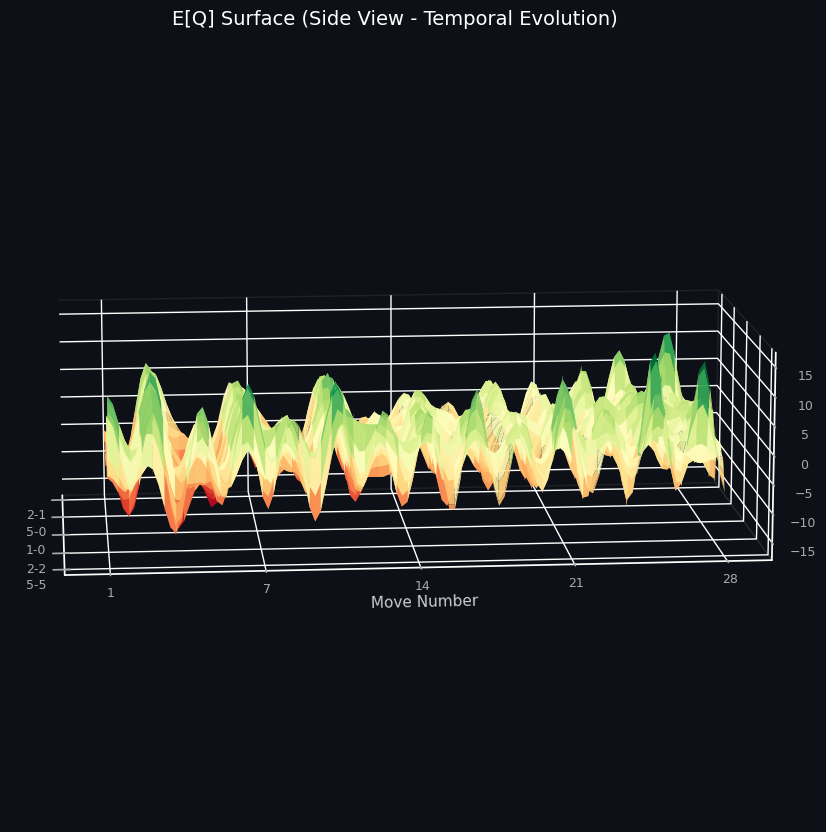

In [8]:
# Side view - dark mode, smooth interpolation
plt.style.use('dark_background')
fig = plt.figure(figsize=(16, 10), facecolor='#0d1117')
ax = fig.add_subplot(111, projection='3d', facecolor='#0d1117')

surf = ax.plot_surface(
    X_mesh, Y_mesh, Z_smooth,
    cmap=cm.RdYlGn,
    linewidth=0,
    antialiased=True,
    alpha=0.95,
    rcount=100,
    ccount=100,
)

# Dark mode styling
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('#333333')
ax.yaxis.pane.set_edgecolor('#333333')
ax.zaxis.pane.set_edgecolor('#333333')
ax.tick_params(colors='#aaaaaa', labelsize=9)
ax.xaxis.label.set_color('#cccccc')
ax.yaxis.label.set_color('#cccccc')
ax.zaxis.label.set_color('#cccccc')

ax.set_xlabel('Domino (sorted)', fontsize=11, labelpad=12)
ax.set_ylabel('Move Number', fontsize=11, labelpad=12)
ax.set_zlabel('E[Q]', fontsize=11, labelpad=8)
ax.set_title('E[Q] Surface (Side View - Temporal Evolution)', fontsize=14, color='white', pad=20)

ax.set_xticks([domino_centers[p] for p in [0, 7, 14, 21, 27]])
ax.set_xticklabels([f"{schema.domino_pips(sorted_domino_idx[p])[0]}-{schema.domino_pips(sorted_domino_idx[p])[1]}" 
                   for p in [0, 7, 14, 21, 27]], fontsize=9)
ax.set_yticks([0, move_length/4, move_length/2, 3*move_length/4, move_length])
ax.set_yticklabels(['1', '7', '14', '21', '28'])

ax.view_init(elev=12, azim=-5)
ax.set_box_aspect([1, 2, 0.6])

plt.tight_layout()
plt.savefig('../../results/figures/27a_eq_surface_side.png', dpi=150, bbox_inches='tight',
            facecolor='#0d1117', edgecolor='none')
plt.show()

## 7. Top-Down and Labeled Views

/tmp/ipykernel_1594397/959520097.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


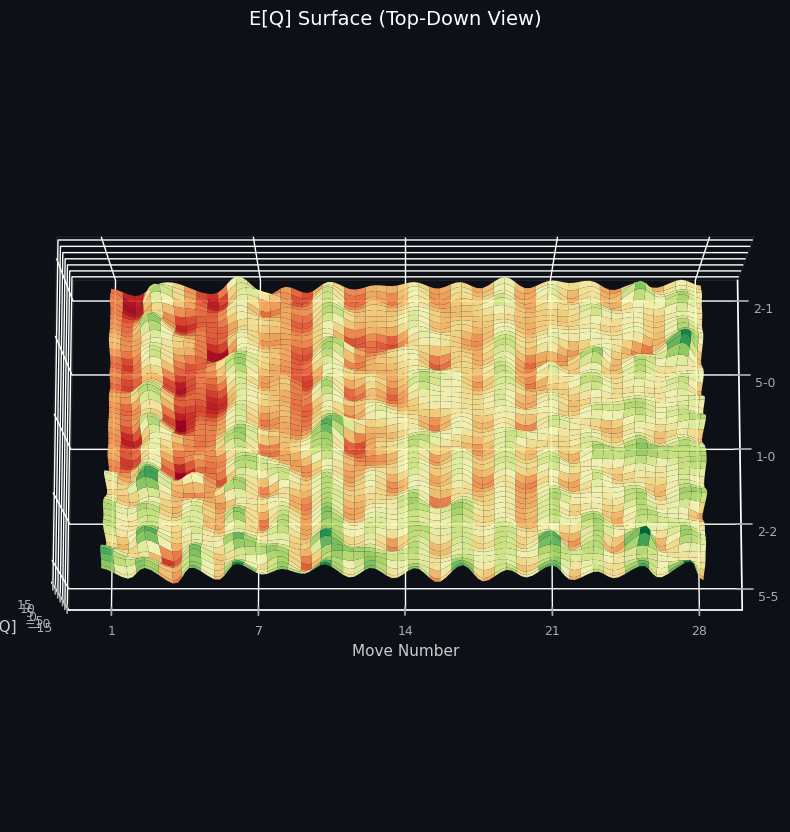

In [9]:
# Top-down view - dark mode, smooth
plt.style.use('dark_background')
fig = plt.figure(figsize=(14, 10), facecolor='#0d1117')
ax = fig.add_subplot(111, projection='3d', facecolor='#0d1117')

surf = ax.plot_surface(
    X_mesh, Y_mesh, Z_smooth,
    cmap=cm.RdYlGn,
    linewidth=0,
    antialiased=True,
    alpha=0.95,
    rcount=100,
    ccount=100,
)

# Dark mode styling
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('#333333')
ax.yaxis.pane.set_edgecolor('#333333')
ax.zaxis.pane.set_edgecolor('#333333')
ax.tick_params(colors='#aaaaaa', labelsize=9)
ax.xaxis.label.set_color('#cccccc')
ax.yaxis.label.set_color('#cccccc')
ax.zaxis.label.set_color('#cccccc')

ax.set_xlabel('Domino (sorted)', fontsize=11, labelpad=12)
ax.set_ylabel('Move Number', fontsize=11, labelpad=12)
ax.set_zlabel('E[Q]', fontsize=11)
ax.set_title('E[Q] Surface (Top-Down View)', fontsize=14, color='white', pad=20)

ax.set_xticks([domino_centers[p] for p in [0, 7, 14, 21, 27]])
ax.set_xticklabels([f"{schema.domino_pips(sorted_domino_idx[p])[0]}-{schema.domino_pips(sorted_domino_idx[p])[1]}" 
                   for p in [0, 7, 14, 21, 27]], fontsize=9)
ax.set_yticks([0, move_length/4, move_length/2, 3*move_length/4, move_length])
ax.set_yticklabels(['1', '7', '14', '21', '28'])

ax.view_init(elev=80, azim=0)
ax.set_box_aspect([1, 2, 0.6])

plt.tight_layout()
plt.savefig('../../results/figures/27a_eq_surface_top.png', dpi=150, bbox_inches='tight',
            facecolor='#0d1117', edgecolor='none')
plt.show()

## 8. Interactive Rotation

In [10]:
# Animated rotation GIF - dark mode, smooth interpolation
from matplotlib.animation import FuncAnimation, PillowWriter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')
fig = plt.figure(figsize=(12, 9), facecolor='#0d1117')
ax = fig.add_subplot(111, projection='3d', facecolor='#0d1117')

def update(frame):
    ax.clear()
    ax.set_facecolor('#0d1117')
    
    surf = ax.plot_surface(
        X_mesh, Y_mesh, Z_smooth,
        cmap=cm.RdYlGn,
        linewidth=0,
        antialiased=True,
        alpha=0.95,
        rcount=80,
        ccount=80,
    )
    
    # Dark mode styling
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('#333333')
    ax.yaxis.pane.set_edgecolor('#333333')
    ax.zaxis.pane.set_edgecolor('#333333')
    ax.tick_params(colors='#aaaaaa', labelsize=8)
    ax.xaxis.label.set_color('#cccccc')
    ax.yaxis.label.set_color('#cccccc')
    ax.zaxis.label.set_color('#cccccc')
    
    ax.set_xlabel('Domino (sorted)', fontsize=10)
    ax.set_ylabel('Move Number', fontsize=10)
    ax.set_zlabel('E[Q]', fontsize=10)
    ax.set_title('E[Q] Surface - Rotating View', fontsize=12, color='white')
    
    ax.set_xticks([domino_centers[p] for p in [0, 14, 27]])
    ax.set_xticklabels(['2-1', '1-0', '5-5'], fontsize=8)
    ax.set_yticks([0, move_length/2, move_length])
    ax.set_yticklabels(['1', '14', '28'])
    
    ax.view_init(elev=20, azim=frame * 3)
    ax.set_box_aspect([1, 2, 0.6])
    return []

anim = FuncAnimation(fig, update, frames=120, interval=50, blit=False)

print("Generating rotation animation...")
writer = PillowWriter(fps=20)
anim.save('../../results/figures/27a_eq_surface_rotate.gif', writer=writer, dpi=80,
          savefig_kwargs={'facecolor': '#0d1117'})
print("✓ Saved: results/figures/27a_eq_surface_rotate.gif")
plt.close()

Generating rotation animation...


✓ Saved: results/figures/27a_eq_surface_rotate.gif


## 9. 2D Heatmap for Comparison

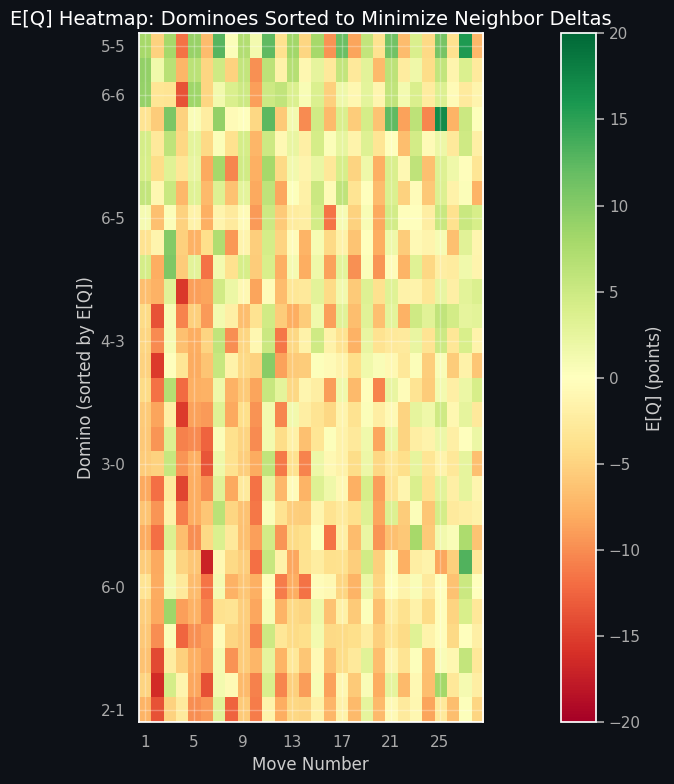

In [11]:
# Heatmap - dark mode
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(16, 8), facecolor='#0d1117')
ax.set_facecolor('#0d1117')

im = ax.imshow(
    eq_matrix_sorted,
    aspect=2.0,
    cmap='RdYlGn',
    origin='lower',
    vmin=-20, vmax=20,
)

ax.set_xlabel('Move Number', fontsize=12, color='#cccccc')
ax.set_ylabel('Domino (sorted by E[Q])', fontsize=12, color='#cccccc')
ax.set_title('E[Q] Heatmap: Dominoes Sorted to Minimize Neighbor Deltas', fontsize=14, color='white')

ax.set_xticks(range(0, 28, 4))
ax.set_xticklabels([str(i+1) for i in range(0, 28, 4)])

tick_positions = [0, 5, 10, 15, 20, 25, 27]
tick_labels = [f"{schema.domino_pips(sorted_domino_idx[p])[0]}-{schema.domino_pips(sorted_domino_idx[p])[1]}" 
               for p in tick_positions]
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)
ax.tick_params(colors='#aaaaaa')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('E[Q] (points)', color='#cccccc')
cbar.ax.yaxis.set_tick_params(color='#aaaaaa')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#aaaaaa')

plt.tight_layout()
plt.savefig('../../results/figures/27a_eq_heatmap.png', dpi=150, bbox_inches='tight',
            facecolor='#0d1117', edgecolor='none')
plt.show()

## 10. Summary Statistics

In [12]:
# Summary statistics already computed above
# eq_by_domino and sorted_domino_idx defined in cell-11

print("Dominoes sorted by average E[Q] (worst to best):")
print("-" * 50)
for i, idx in enumerate(sorted_domino_idx):
    pips = schema.domino_pips(idx)
    print(f"{i+1:2}. {pips[0]}-{pips[1]:2} (ID {idx:2}): E[Q] = {eq_by_domino[idx]:+.2f}")

Dominoes sorted by average E[Q] (worst to best):
--------------------------------------------------
 1. 2- 1 (ID  4): E[Q] = -5.05
 2. 3- 2 (ID  8): E[Q] = -3.86
 3. 5- 1 (ID 16): E[Q] = -3.78
 4. 3- 1 (ID  7): E[Q] = -3.76
 5. 2- 0 (ID  3): E[Q] = -3.70
 6. 6- 0 (ID 21): E[Q] = -3.69
 7. 4- 1 (ID 11): E[Q] = -3.62
 8. 5- 0 (ID 15): E[Q] = -3.57
 9. 4- 2 (ID 12): E[Q] = -3.51
10. 5- 2 (ID 17): E[Q] = -3.48
11. 3- 0 (ID  6): E[Q] = -3.38
12. 6- 3 (ID 24): E[Q] = -3.33
13. 6- 1 (ID 22): E[Q] = -3.22
14. 4- 0 (ID 10): E[Q] = -2.99
15. 1- 0 (ID  1): E[Q] = -2.79
16. 4- 3 (ID 13): E[Q] = -2.39
17. 5- 4 (ID 19): E[Q] = -2.25
18. 5- 3 (ID 18): E[Q] = -2.22
19. 0- 0 (ID  0): E[Q] = -2.10
20. 6- 2 (ID 23): E[Q] = -2.06
21. 6- 5 (ID 26): E[Q] = -1.58
22. 2- 2 (ID  5): E[Q] = -0.93
23. 3- 3 (ID  9): E[Q] = -0.41
24. 1- 1 (ID  2): E[Q] = +0.15
25. 6- 4 (ID 25): E[Q] = +0.18
26. 6- 6 (ID 27): E[Q] = +0.61
27. 4- 4 (ID 14): E[Q] = +0.82
28. 5- 5 (ID 20): E[Q] = +2.04


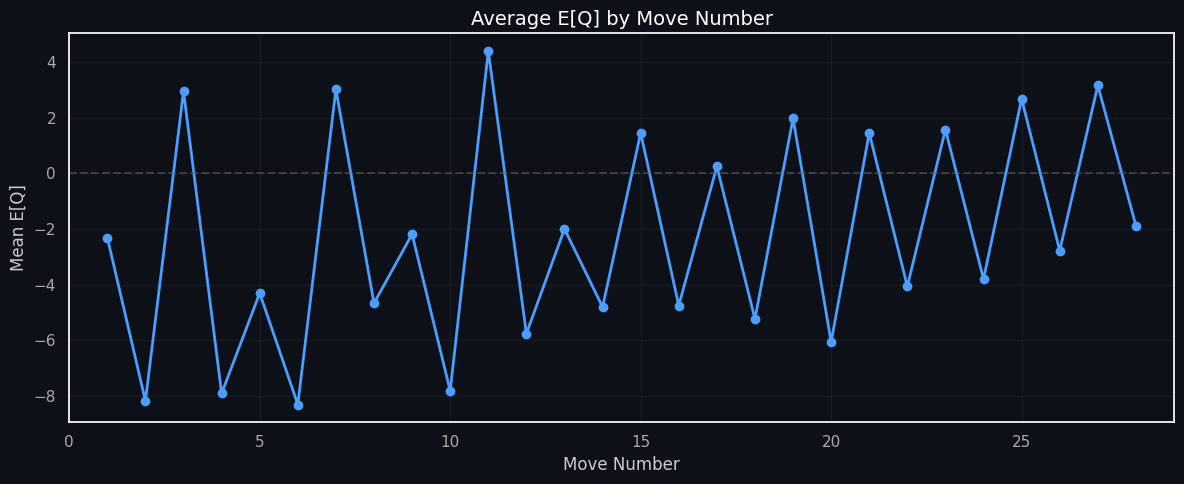

In [13]:
# E[Q] by move number - dark mode
eq_by_move = np.nanmean(eq_matrix, axis=0)

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 5), facecolor='#0d1117')
ax.set_facecolor('#0d1117')

ax.plot(range(1, 29), eq_by_move, 'o-', color='#4a9eff', linewidth=2, markersize=6)
ax.axhline(0, color='#666666', linestyle='--', alpha=0.5)

ax.set_xlabel('Move Number', fontsize=12, color='#cccccc')
ax.set_ylabel('Mean E[Q]', fontsize=12, color='#cccccc')
ax.set_title('Average E[Q] by Move Number', fontsize=14, color='white')
ax.set_xlim(0, 29)
ax.tick_params(colors='#aaaaaa')
ax.grid(alpha=0.2, color='#444444')

plt.tight_layout()
plt.savefig('../../results/figures/27a_eq_by_move.png', dpi=150, bbox_inches='tight',
            facecolor='#0d1117', edgecolor='none')
plt.show()

## 11. Save Data

In [14]:
# Export to JSONL for web visualization
import json

# Structure: one line per game with all E[Q] data
# For now, we have aggregated data across 250 games - export as single "aggregate" entry

output_path = '../../results/data/27a_eq_surface.jsonl'
import os
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Build the data structure
game_data = {
    "game_id": "aggregate_250games",
    "n_games": 250,
    "dominoes": [],  # List of {id, pips, position, mean_eq}
    "moves": list(range(1, 29)),  # 1-28
    "eq_matrix": [],  # 28 dominoes x 28 moves
    "domino_order": list(map(int, sorted_domino_idx)),  # Sorted order for smooth visualization
}

# Add domino metadata
for pos, dom_id in enumerate(sorted_domino_idx):
    pips = schema.domino_pips(dom_id)
    game_data["dominoes"].append({
        "id": int(dom_id),
        "pips": f"{pips[0]}-{pips[1]}",
        "high": int(pips[0]),
        "low": int(pips[1]),
        "position": pos,  # Position in sorted order
        "mean_eq": float(eq_by_domino[dom_id]),
    })

# Add E[Q] matrix (sorted order)
for d_idx in range(28):
    row = []
    for m_idx in range(28):
        val = eq_matrix_sorted[d_idx, m_idx]
        row.append(float(val) if not np.isnan(val) else None)
    game_data["eq_matrix"].append(row)

# Write JSONL
with open(output_path, 'w') as f:
    f.write(json.dumps(game_data) + '\n')

print(f"✓ Saved: {output_path}")
print(f"  - {len(game_data['dominoes'])} dominoes")
print(f"  - {len(game_data['moves'])} moves")
print(f"  - Matrix shape: {len(game_data['eq_matrix'])}x{len(game_data['eq_matrix'][0])}")

✓ Saved: ../../results/data/27a_eq_surface.jsonl
  - 28 dominoes
  - 28 moves
  - Matrix shape: 28x28


## Summary

Created 3D visualization of E[Q] values across all 28 dominoes and 28 move numbers.

**Static Figures (matplotlib):**
- `results/figures/27a_eq_surface_3d.png` - Main 3D surface (dark mode, smooth)
- `results/figures/27a_eq_ribbons.png` - Separate strips per domino with gaps
- `results/figures/27a_eq_surface_side.png` - Side view (temporal)
- `results/figures/27a_eq_surface_top.png` - Top-down view
- `results/figures/27a_eq_surface_rotate.gif` - Animated rotation
- `results/figures/27a_eq_heatmap.png` - 2D heatmap
- `results/figures/27a_eq_by_move.png` - E[Q] vs move number

**Data Files:**
- `results/tables/27a_eq_matrix.csv` - Raw E[Q] data (sorted)
- `results/tables/27a_eq_counts.csv` - Sample counts
- `results/tables/27a_domino_order.csv` - Domino sort order
- `results/data/27a_eq_surface.jsonl` - **JSONL for web visualization**

**Web Visualization:**
- `results/web/eq_surface_3d.html` - Interactive Three.js 3D viewer

**To view the web visualization:**
```bash
cd forge/analysis/results
python serve.py
# Open http://localhost:8000/web/eq_surface_3d.html
```

**JSONL Schema:**
```json
{
  "game_id": "string",
  "n_games": 250,
  "dominoes": [{"id": 4, "pips": "2-1", "high": 2, "low": 1, "position": 0, "mean_eq": -5.05}, ...],
  "moves": [1, 2, ..., 28],
  "eq_matrix": [[...], ...],  // 28 dominoes × 28 moves
  "domino_order": [4, 8, 16, ...]  // Sorted by E[Q]
}
```